# Regress the Adjacency Matrix
Vivek Gopalakrishnan | February 25, 2019

## Overview:
Try to learn a model for the adjacency matrix using index and batch ID as input variables.

## Contents
1. Input

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import networkx as nx
import graspy as gs
from graspy.utils import import_graph

from collections import OrderedDict
import os

### 1. Import data and embed

**PROCEDURE:**
1. Import the data 
2. Visualize the data as a sanity check

In [2]:
# Import data

hbn = []
hnu = []

# Load HBN
for root, dirs, files in os.walk('../../data/HBN'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_weighted_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                hbn.append(G)
            
# Load HNU1
for root, dirs, files in os.walk('../../data/HNU1'):
    
    for graph in files:
        if graph.endswith(".edgelist"):
            graph_path = os.path.join(root, graph)
            G = nx.read_edgelist(graph_path)
            G = gs.utils.pass_to_ranks(G)
            if G.shape == (70, 70):
                hnu.append(G)

# Convert to numpy array
hbn = np.array(hbn)
hnu = np.array(hnu)
print("Number of patients in HBN: {}".format(len(hbn)))
print("Number of patients in HNU1: {}".format(len(hnu)))

Number of patients in HBN: 99
Number of patients in HNU1: 300


Embedding shapes:
 (3500, 50)
 (3500, 50)

Stacked embedding shape:
 (7000, 50)

Tensor embedding shape:
 (100, 70, 50)

cMDS shape:
 (100, 20)



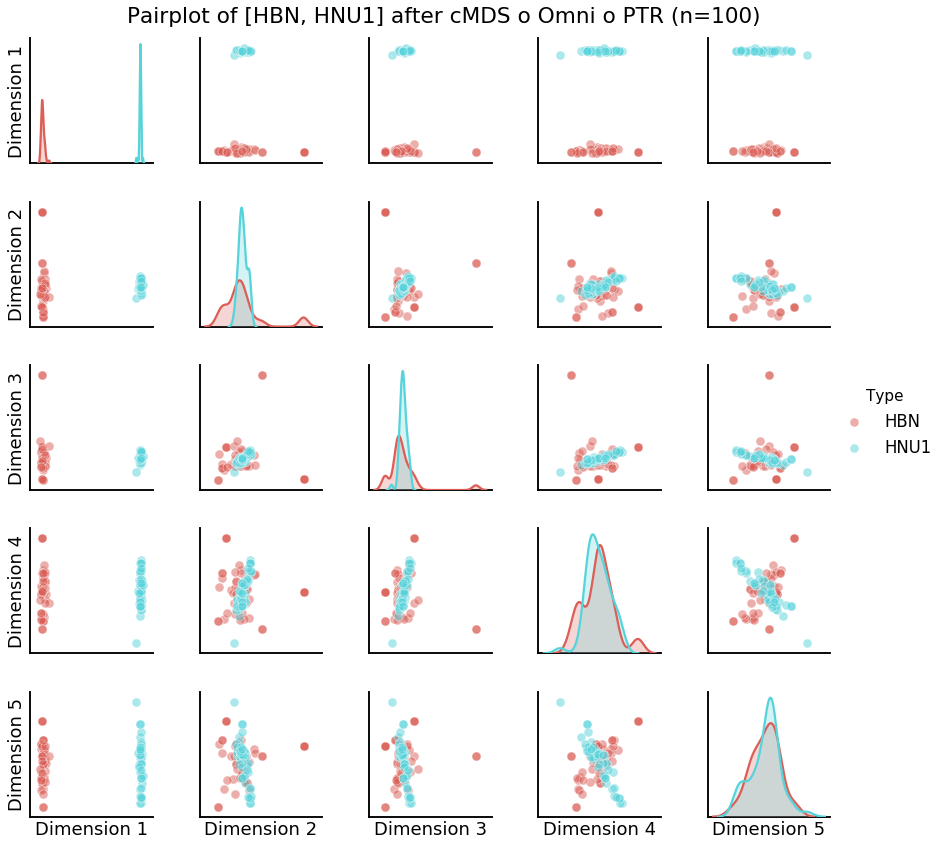

In [3]:
# Visualize data for sanity

def embed(data, n_components=50, n_population=75):
    """Embed a subset of an array of connectomes (data) in specified number of dimensions."""
    
    omni = gs.embed.OmnibusEmbed(n_components=n_components)
    Zhat = omni.fit_transform(
        data[np.random.choice(len(data), size=n_population)]
    )
    
    return Zhat

# Constants
n_components = 50
n_population = 50

# Embed the data
Zhat_hbn = embed(hbn, n_population=n_population)
Zhat_hnu = embed(hnu, n_population=n_population)

# Verify embedding shapes for sanity
print("Embedding shapes:\n {}\n {}\n".format(
    Zhat_hbn.shape, 
    Zhat_hnu.shape,
))

# Combine embeddings
Zhat = np.vstack([Zhat_hbn, Zhat_hnu])
print("Stacked embedding shape:\n {}\n".format(Zhat.shape))

# Tensor: subject x node x Euclidean representation
Zhat = Zhat.reshape((n_population * 2, 70, -1))
print("Tensor embedding shape:\n {}\n".format(Zhat.shape))

# Dim reduce: subject x components
cmds = gs.embed.ClassicalMDS(n_components=20)
Xhat = cmds.fit_transform(Zhat)
print("cMDS shape:\n {}\n".format(Xhat.shape))

# Labels for dimensions
variables = ['Dimension {}'.format(i) for i in range(1, Xhat.shape[1] + 1)]
labels = ['HBN']*n_population + ['HNU1']*n_population

# Pair plot of first 5 components of CMDS
gs.plot.pairplot(
    Xhat, 
    alpha=0.5,
    Y=labels, 
    palette='hls', 
    col_names=variables, 
    variables=variables[:5], 
    title='Pairplot of [HBN, HNU1] after cMDS o Omni o PTR (n={})'.format(n_population*2)
)

plt.show()

### 2. Vectorize connectomes and make data matrices

In [4]:
def construct_flattened_regressor(data, n_population, batch_id):
    
    # Subsample the data
    sub = data[np.random.choice(len(data), size=n_population)]
    
    X = []
    Y = []

    for i in range(sub.shape[0]):
        for j in range(sub.shape[1]):
            for k in range(sub.shape[2]):
                X.append([i,j,batch_id])
                Y.append(sub[i,j,k])
                
    X = np.array(X)
    Y = np.array(Y).reshape(-1, 1)
    
    return X, Y

In [5]:
def construct_flattened_regressor(data, n_population, batch_id):
    
    # Subsample the data
    sub = data[np.random.choice(len(data), size=n_population)]
    
    X = []

    for i in range(sub.shape[0]):
        for j in range(sub.shape[1]):
            for k in range(sub.shape[2]):
                X.append([i,j,batch_id])
                
    X = np.array(X)
    Y = sub.reshape(-1, 1)
    
    return X, Y

In [6]:
# Constants
n_population = 50

# Sample the data
hbn_X, hbn_Y = construct_flattened_regressor(hbn, n_population=n_population, batch_id=0)
hnu_X, hnu_Y = construct_flattened_regressor(hnu, n_population=n_population, batch_id=1)

print("Data matrix shapes")
print(hbn_X.shape)
print(hbn_Y.shape)
print(hnu_X.shape)
print(hnu_Y.shape)

# Combine datasets
X = np.vstack([hbn_X, hnu_X])
Y = np.vstack([hbn_Y, hnu_Y])

print("\nAggregated matrix shapes")
print(X.shape)
print(Y.shape)

Data matrix shapes
(245000, 3)
(245000, 1)
(245000, 3)
(245000, 1)

Aggregated matrix shapes
(490000, 3)
(490000, 1)


In [7]:
# Linear regression
from sklearn.linear_model import LinearRegression

# Regress out the batch
lr = LinearRegression()
lr.fit(X, Y)
Y_reg = Y - lr.predict(X)
Y_reg = Y_reg.reshape(70,70,-1)

print(Y_reg.shape)

(70, 70, 100)


In [8]:
hbn_reg = [Y_reg[:,:,i] for i in range(n_population)]
hnu_reg = [Y_reg[:,:,i] for i in range(n_population,2*n_population)]

In [9]:
omni = gs.embed.OmnibusEmbed(n_components=50)
Zhat_hbn = omni.fit_transform(hbn_reg)

omni = gs.embed.OmnibusEmbed(n_components=50)
Zhat_hnu = omni.fit_transform(hnu_reg)

In [10]:
# Combine embeddings
Zhat = np.vstack([Zhat_hbn, Zhat_hnu])
print(Zhat.shape)

# Tensor: subject x node x Euclidean representation
Zhat = Zhat.reshape((n_population * 2, 70, -1))
print(Zhat.shape)

# Dim reduce: subject x components
cmds = gs.embed.ClassicalMDS(n_components=20)
Xhat = cmds.fit_transform(Zhat)
print(Xhat.shape)

(4, 3500, 50)
(100, 70, 100)
(100, 20)


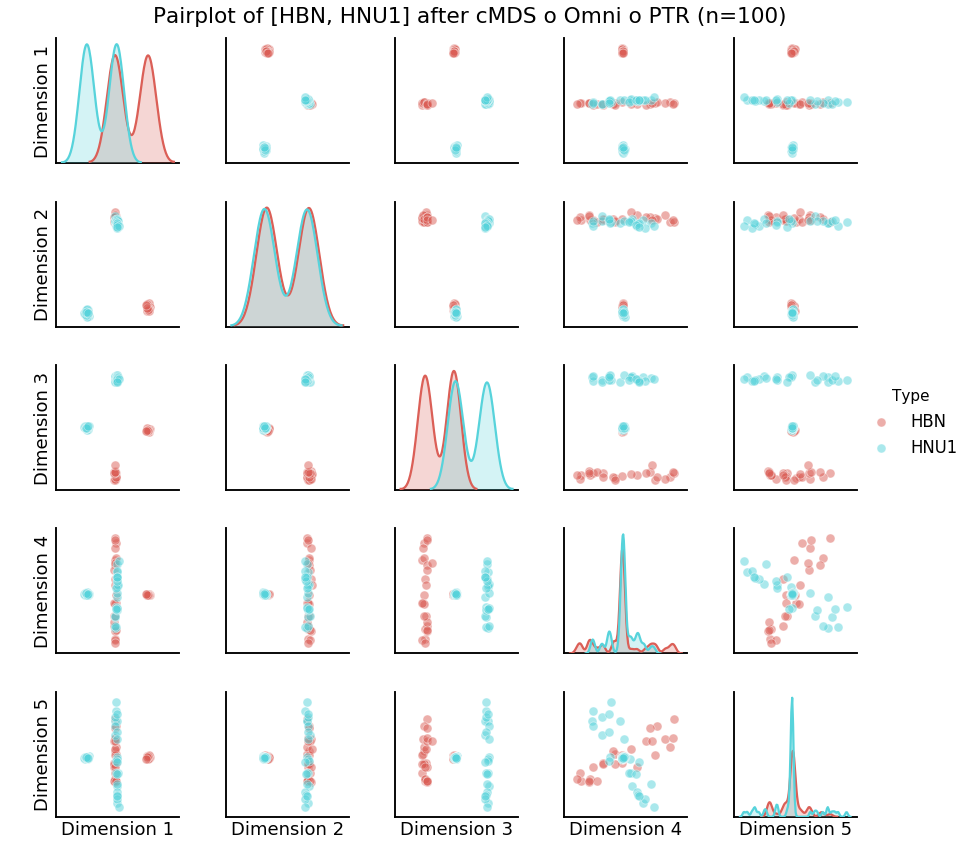

In [11]:
# Labels for dimensions
variables = ['Dimension {}'.format(i) for i in range(1, Xhat.shape[1] + 1)]
labels = ['HBN']*n_population + ['HNU1']*n_population

# Pair plot of first 5 components of CMDS
gs.plot.pairplot(
    Xhat, 
    alpha=0.5,
    Y=labels, 
    palette='hls', 
    col_names=variables, 
    variables=variables[:5], 
    title='Pairplot of [HBN, HNU1] after cMDS o Omni o PTR (n={})'.format(n_population*2)
)

plt.show()